# **CUHK-STAT3009**: Homework 3 - Neural Network in RS: Models, Algorithm, and virtualization (**due Nov 30**)

-   Note that we use the same notations in the STAT3009 slides


In [3]:
import numpy as np
import pandas as pd

## **Q1: Data preprocessing**


In [4]:
## use iris dataset in Q1
from sklearn.datasets import load_iris

data = load_iris(as_frame=True)

### **Q1.1**

-   Standardize features by removing the mean and scaling to unit variance.
-   Merge `data.data` and `data.target` as a one `dataframe` with columns: [`sepal length (cm)`, `sepal width (cm)`, `petal length (cm)`, `petal width (cm)`, `target`]
-   Compute the target-specific mean of each features, that is,

                sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
        target
        0                   5.006             3.428              1.462             0.246
        1                   5.936             2.770              4.260             1.326
        2                   6.588             2.974              5.552             2.026


In [15]:
## Your solution to Q1.1 here
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data.data)
merged = pd.concat([data.data, data.target], axis=1)

merged.groupby(by="target").mean()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
target,,,,
0,5.006,3.428,1.462,0.246
1,5.936,2.770,4.260,1.326
2,6.588,2.974,5.552,2.026


In [17]:
# target specific mean for scaled data:
scaled_merged = pd.concat(
    [pd.DataFrame(scaled_data, columns=data.data.columns), data.target], axis=1
)

scaled_merged.groupby(by="target").mean()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
target,,,,
0,-1.014579,0.853263,-1.304987,-1.254893
1,0.112282,-0.661432,0.285324,0.166734
2,0.902297,-0.191831,1.019663,1.088159


### **Q1.2**

-   Using `seaborn` to show the `Violinplot` of all features against `target`
-   Using `seaborn` to show the `heatmap` of the correlation between all features


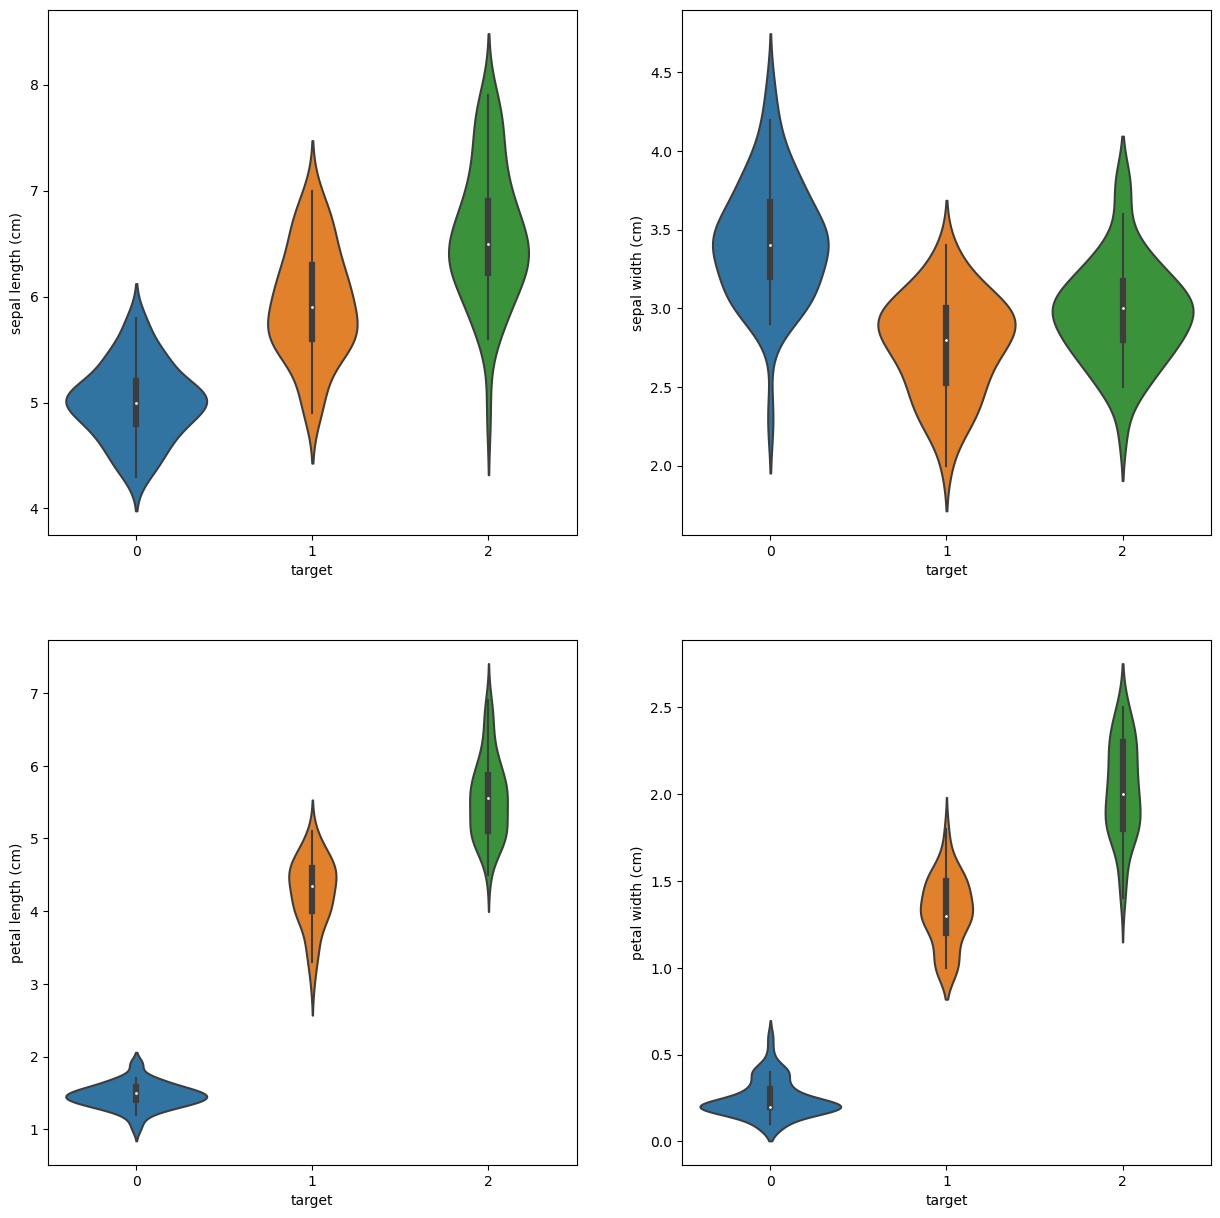

<Axes: >

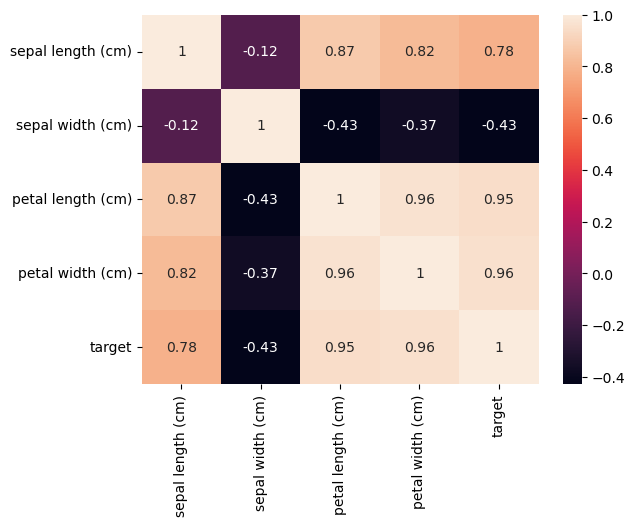

In [19]:
## Your solution to Q1.2 here
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(2, 2, figsize=(15, 15))
ax = ax.flatten()
for i in range(4):
    sns.violinplot(merged, x="target", y=data.data.columns[i], ax=ax[i])
plt.show()
sns.heatmap(merged.corr(), annot=True)

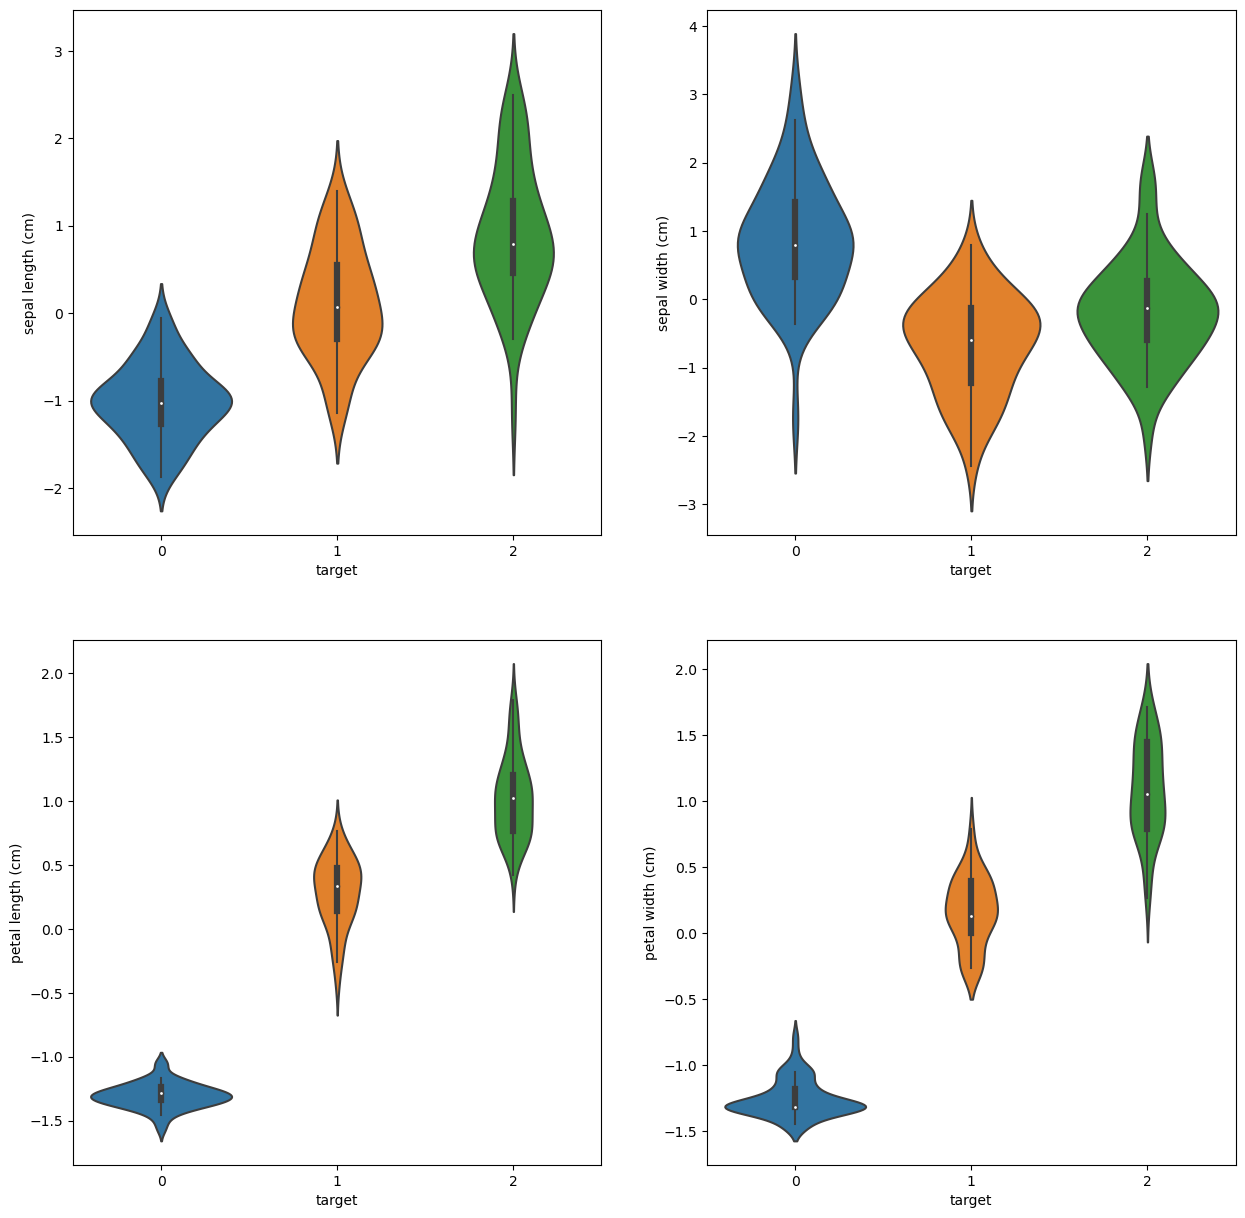

<Axes: >

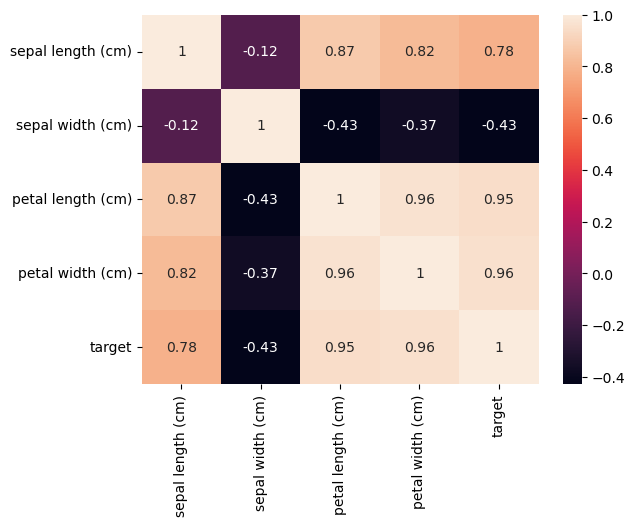

In [20]:
# with scaled data
fig, ax = plt.subplots(2, 2, figsize=(15, 15))
ax = ax.flatten()
for i in range(4):
    sns.violinplot(scaled_merged, x="target", y=data.data.columns[i], ax=ax[i])
plt.show()
sns.heatmap(scaled_merged.corr(), annot=True)

## **Q2. Semi-parametric model**

A semi-parametric model is widely used in statistical learning, machine learning, and deep learning. Given a feature-vector $\mathbf{x}$, the outcome is formulated as:

$$
f(\mathbf{x}) = \mathbf{\beta}^\intercal \mathbf{x} + h(\mathbf{x}),
$$

where $\mathbf{\beta}$ is a linear coefficient, and $h(\cdot)$ is a nonlinear function. In this question, you are expected to use $f(\mathbf{x})$ to make prediction in `California Housing dataset` based on `tensorflow`


In [22]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

X, y = fetch_california_housing(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

### **Q2.1**

-   Standardize features of by removing the mean and scaling to unit variance.
-   Using `tensorflow` build up a network for the model $f(\mathbf{x})$ with $h(\mathbf{x})$ as two `Dense` layers: `Dense(8, activation='relu')` + `Dense(1, activation='linear')`
-   Print `model.summary()` for your model


In [31]:
## Your solution to Q2.1 here
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)


class SemiParametric(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.beta = tf.keras.layers.Dense(
            1, activation="linear", use_bias=False, input_shape=(X_train.shape[-1],)
        )
        self.h = tf.keras.Sequential(
            [
                tf.keras.layers.Dense(
                    8, activation="relu", input_shape=(X_train.shape[-1],)
                ),
                tf.keras.layers.Dense(1, activation="linear"),
            ]
        )

    def call(self, inputs):
        return self.beta(inputs) + self.h(inputs)


model = SemiParametric()
model.build(input_shape=[None, X_train.shape[-1]])
model.call(
    tf.keras.Input(
        shape=X_train.shape[-1],
    )
)
print(model.summary())

Model: "semi_parametric_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


 dense_20 (Dense)            (None, 1)                 8         
                                                                 
 sequential_6 (Sequential)   (None, 1)                 81        
                                                                 
Total params: 89 (356.00 Byte)
Trainable params: 89 (356.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


### **Q2.2**

-   Compile the model with `loss`: [MAE](https://keras.io/api/losses/regression_losses/#meanabsoluteerror-class); `optimizer`: [SGD](https://keras.io/api/optimizers/sgd/); and monitoring `Metrics`: `RMSE`

-   fit model

    -   using `X_train`, `y_train`
    -   taking 20% of data as validation set
    -   [earlystopping](https://keras.io/api/callbacks/) based on `RMSE` on `validation set` with custom `patience` and other hyperparamters

-   Make prediction to `X_test`, and evaluate the prediction by reporting `RMSE` and `MAE`.


In [32]:
## Your solution to Q2.2 here
metrics = [
    tf.keras.metrics.RootMeanSquaredError(name="rmse"),
]

model.compile(
    optimizer=tf.keras.optimizers.SGD(1e-2),
    loss=tf.keras.losses.MeanAbsoluteError(),
    metrics=metrics,
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_rmse",
        min_delta=0,
        patience=5,
        verbose=1,
        mode="auto",
        baseline=None,
        restore_best_weights=True,
    )
]

model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=1000,
    verbose=2,
    validation_split=0.2,
    callbacks=callbacks,
)

Epoch 1/1000
173/173 - 0s - loss: 1.3570 - rmse: 1.8752 - val_loss: 0.7884 - val_rmse: 1.1135 - 304ms/epoch - 2ms/step
Epoch 2/1000
173/173 - 0s - loss: 0.7032 - rmse: 1.0140 - val_loss: 0.6590 - val_rmse: 0.9482 - 67ms/epoch - 389us/step
Epoch 3/1000
173/173 - 0s - loss: 0.6236 - rmse: 0.9264 - val_loss: 0.6080 - val_rmse: 0.8898 - 66ms/epoch - 380us/step
Epoch 4/1000
173/173 - 0s - loss: 0.5808 - rmse: 0.8716 - val_loss: 0.5770 - val_rmse: 0.8536 - 64ms/epoch - 369us/step
Epoch 5/1000
173/173 - 0s - loss: 0.5544 - rmse: 0.8322 - val_loss: 0.5563 - val_rmse: 0.8252 - 67ms/epoch - 385us/step
Epoch 6/1000
173/173 - 0s - loss: 0.5375 - rmse: 0.8028 - val_loss: 0.5448 - val_rmse: 0.8026 - 64ms/epoch - 371us/step
Epoch 7/1000
173/173 - 0s - loss: 0.5269 - rmse: 0.7822 - val_loss: 0.5353 - val_rmse: 0.7929 - 64ms/epoch - 369us/step
Epoch 8/1000
173/173 - 0s - loss: 0.5195 - rmse: 0.7675 - val_loss: 0.5288 - val_rmse: 0.7794 - 63ms/epoch - 365us/step
Epoch 9/1000
173/173 - 0s - loss: 0.5134 

In [33]:
# Note: loss is MAE
print(list(zip(model.metrics_names, model.evaluate(X_test, y_test))))

213/213 [==============================] - 0s 460us/step - loss: 0.4716 - rmse: 0.6711
[('loss', 0.47159862518310547), ('rmse', 0.6711490154266357)]


## **Q3 (Bonus): Gradient Descent for Binary MF**

For many recommender systems, the rating (or response) is a binary label, say like/dislike; up/down; negtive/positive, and so on. In this content, our goal is to formulate the conditional probability instead of the rating. Specifically, we assume that the probability of $r_{ui} = 1$ follows MF models:

$$
\mathbb{P}( r_{ui} = 1 ) = \frac{1}{1 + \exp^{- \mathbf{p}_u^\intercal \mathbf{q}_i}}.
$$

Then, given a training dataset $(r_{ui})_{(u,i) \in \Omega}$, where $r_{ui} \in \{0, 1\}$, we use Maximum Likelihood Estimator to estimate $\mathbf{P}$ and $\mathbf{Q}$:

$$
(\widehat{\mathbf P}, \widehat{\mathbf Q}) = \text{argmin}_{\mathbf{P}, \mathbf{Q}} - \sum_{(u,i) \in \Omega} \big( r_{ui} \log( \frac{1}{1 + \exp^{- \mathbf{p}_u^\intercal \mathbf{q}_i }} ) + (1 - r_{ui}) \log( 1 - \frac{1}{1 + \exp^{- \mathbf{p}_u^\intercal \mathbf{q}_i }} ) \big). \quad (1)
$$

Once $(\widehat{\mathbf P}, \widehat{\mathbf Q})$ is estimated, we can predict $r_{ui}$ as:

$$
\widehat{r}_{ui} = 1, \text{ if } ( \frac{1}{1 + \exp^{- \mathbf{p}_u^\intercal \mathbf{q}_i }}) > 0.5, \quad \widehat{r}_{ui} = 0, \text{ otherwise } \qquad (2)
$$

-   **RK**: we can add regularization in the optimization if you want.


In [72]:
import numpy as np


def acc(true_rating, pred_rating):
    return np.mean(true_rating == pred_rating)

In [73]:
## Dowload binary dataset in CUHK-STAT3009 Github repo

train_url = "https://raw.githubusercontent.com/statmlben/CUHK-STAT3009/main/dataset/b-rs/train.csv"
test_url = "https://raw.githubusercontent.com/statmlben/CUHK-STAT3009/main/dataset/b-rs/test.csv"

dtrain = pd.read_csv(train_url)
dtest = pd.read_csv(test_url)

train_rating = dtrain["rating"].values
train_rating = np.array(train_rating, dtype=float)
train_pair = dtrain[["user_id", "movie_id"]].values

test_rating = dtest["rating"].values
test_rating = np.array(test_rating, dtype=float)
test_pair = dtest[["user_id", "movie_id"]].values

n_user = max(max(train_pair[:, 0]), max(test_pair[:, 0])) + 1
n_item = max(max(train_pair[:, 1]), max(test_pair[:, 1])) + 1

### **Q3.1**

-   Implement the minimization in (1) via **tensorflow** by using proper **loss** and **activation**([sigmoid](https://www.tensorflow.org/api_docs/python/tf/math/sigmoid)) functions

    -   using `train_pair`, `train_rating`
    -   taking 20% of data as validation set
    -   [earlystopping](https://keras.io/api/callbacks/) based on `Acc` on `validation set` with custom `patience` and other hyperparamters

-   Make prediction to `test_pair` based on (2), and evaluate the prediction by reporting `Acc`.


In [132]:
## Your solution to Q3.1 here
class BinaryMF(tf.keras.Model):
    def __init__(self, num_user, num_items, embedding_size):
        super().__init__()
        self.num_user = num_user
        self.num_items = num_items
        self.user_embedding = tf.keras.layers.Embedding(self.num_user, embedding_size)
        self.item_embedding = tf.keras.layers.Embedding(self.num_items, embedding_size)

    def call(self, inputs):
        results = tf.math.sigmoid(
            tf.reduce_sum(
                self.user_embedding(inputs[:, 0]) * self.item_embedding(inputs[:, 1]),
                axis=1,
                keepdims=True,
            )
        )
        return results

In [136]:
model = BinaryMF(n_user, n_item, 2)
metrics = [
    tf.keras.metrics.BinaryAccuracy(name="acc"),
]

model.compile(
    optimizer=tf.keras.optimizers.SGD(1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=metrics,
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_acc",
        min_delta=0,
        patience=5,
        verbose=1,
        mode="auto",
        baseline=None,
        restore_best_weights=True,
    )
]

model.fit(
    train_pair,
    train_rating,
    batch_size=64,
    epochs=1000,
    verbose=2,
    validation_split=0.2,
    callbacks=callbacks,
)

Epoch 1/1000
640/640 - 0s - loss: 0.6932 - acc: 0.4982 - val_loss: 0.6931 - val_acc: 0.5029 - 424ms/epoch - 662us/step
Epoch 2/1000
640/640 - 0s - loss: 0.6932 - acc: 0.4983 - val_loss: 0.6931 - val_acc: 0.5029 - 224ms/epoch - 351us/step
Epoch 3/1000
640/640 - 0s - loss: 0.6932 - acc: 0.4982 - val_loss: 0.6931 - val_acc: 0.5029 - 236ms/epoch - 369us/step
Epoch 4/1000
640/640 - 0s - loss: 0.6932 - acc: 0.4982 - val_loss: 0.6931 - val_acc: 0.5030 - 226ms/epoch - 353us/step
Epoch 5/1000
640/640 - 0s - loss: 0.6932 - acc: 0.4983 - val_loss: 0.6931 - val_acc: 0.5032 - 224ms/epoch - 350us/step
Epoch 6/1000
640/640 - 0s - loss: 0.6932 - acc: 0.4983 - val_loss: 0.6931 - val_acc: 0.5033 - 228ms/epoch - 356us/step
Epoch 7/1000
640/640 - 0s - loss: 0.6932 - acc: 0.4983 - val_loss: 0.6931 - val_acc: 0.5032 - 230ms/epoch - 360us/step
Epoch 8/1000
640/640 - 0s - loss: 0.6932 - acc: 0.4984 - val_loss: 0.6931 - val_acc: 0.5032 - 226ms/epoch - 353us/step
Epoch 9/1000
640/640 - 0s - loss: 0.6932 - acc: 

In [137]:
model.evaluate(test_pair, test_rating)

1599/1599 [==============================] - 1s 308us/step - loss: 0.6931 - acc: 0.5036


[0.6931419372558594, 0.5035867094993591]